# RBM training $ L=48$  - Dataset with 29 different temperatures

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import seaborn as sns

import torch
import torch.nn as nn
torch.manual_seed(12)

import sys
sys.path.append('../modules')
from rbm import RBM
from mc_ising2d import IsingMC

L = 48

## Loading Ising data

The first step is to load the Ising data generated by Monte Carlo procedure. The file `L036_Ising2D_MC.pkl` was constructed considering a square lattice $L\times L$, with $L=36$. There are 1000 spins configurations for each of 29 different temperatures $ T/J = 1, 1.1, 1.2, ..., 3,5 $ and $ T/J = 2.259, 2.269, 2.279$.

In [8]:
ising_data = pd.read_pickle('../data/L048_Ising2D_MC.pkl')
ising_data.head()

,energy,magn,state,temp
0,-1468,42,"[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...",3.5
1,-1736,-64,"[1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, ...",3.5
2,-1540,-18,"[1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, ...",3.5
3,-1460,-72,"[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, ...",3.5
4,-1380,-104,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",3.5


In [9]:
ising_data['temp'].value_counts()

2.279185    1000
1.600000    1000
3.000000    1000
2.000000    1000
1.500000    1000
1.000000    1000
3.200000    1000
2.259185    1000
2.300000    1000
2.269185    1000
1.100000    1000
1.800000    1000
1.400000    1000
1.700000    1000
2.200000    1000
2.900000    1000
2.400000    1000
1.900000    1000
3.400000    1000
1.200000    1000
2.500000    1000
3.100000    1000
2.100000    1000
2.800000    1000
2.600000    1000
2.700000    1000
1.300000    1000
3.300000    1000
3.500000    1000
Name: temp, dtype: int64

In the thermodynamic limit $( L^2 \rightarrow \infty )$, the isotropic Ising model in a square lattice was analytically solved by [Lars Onsager](https://en.wikipedia.org/wiki/Lars_Onsager) in [1944](https://journals.aps.org/pr/abstract/10.1103/PhysRev.65.117). In this limit, the model show spontaneous magnetization for $ T < T_c$, with $T_c$ given by 

$$ \frac{T_c}{J} = \frac{2}{\log\left(1 + \sqrt{ 2}\right)} \approx 2.269185  \;. $$

With the class `IsingMC` we can check some thermodynamics quantities.

Method fit will construct states to the following temperatures: 
[3.5        3.4        3.3        3.2        3.1        3.
 2.9        2.8        2.7        2.6        2.5        2.4
 2.3        2.27918531 2.26918531 2.25918531 2.2        2.1
 2.         1.9        1.8        1.7        1.6        1.5
 1.4        1.3        1.2        1.1        1.        ]


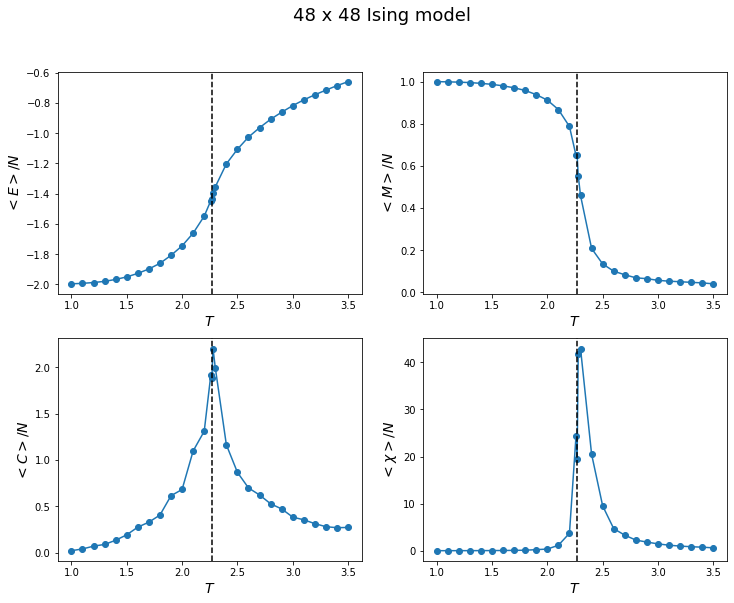

In [10]:
IsingMC(L= 48).plot_thermodynamics(spin_MC= ising_data, Tc_scaled= False)

In [11]:
data = ising_data.drop(columns= ['energy', 'magn'])

### Constructing training and test sets

Using `train_test_split` from [`sklearn`](http://scikit-learn.org/) it is easy to split the data into training and test sets. Since `train_test_split` is a random process and our data has 1000 samples for each of the 29 temperatures values, we split the data for each temperature in order to avoid the possibility of a biased split towards some temperature value.

In [12]:
train_data_ = pd.DataFrame()
test_data_ = pd.DataFrame()

for _, temp in enumerate(data['temp'].value_counts().index.tolist()):
    
    train_data_T, test_data_T = train_test_split(data[data['temp'] == temp],
                                                 test_size= 0.2,
                                                 random_state= 12)
    
    train_data_ = pd.concat([train_data_, train_data_T])
    test_data_ = pd.concat([test_data_, test_data_T])

### Training the model

Our code implementing a Restricted Boltzmann Machine is written a python class called `RBM` which is imported from `rbm.py`.

For simplification, the units have no bias and the RBM stochasticity parameter, represented below by $T$ is set to unity, as usual in most practical applications. Note that we set `use_cuda=True`, which makes use of [CUDA tensor types](https://pytorch.org/docs/stable/cuda.html), implementing GPU computation. If a GPU is not available, one should just set `use_cuda=False`.

RBM --- Nv= 2304, Nh= 2304, lr= 1.0E-03, k= 1, Bsize= 100, Epochs= 3000, USE_CUDA= True, verbose= 1
Starting training
Ep 1, Rec er: 0.314271 (train), 0.302813 (test), Pseud_Lik: -1412.854079, Time: 9.485881, 
Ep 2, Rec er: 0.301136 (train), 0.300148 (test), Pseud_Lik: -1129.532104, Time: 10.290205, 
Ep 3, Rec er: 0.299004 (train), 0.298336 (test), Pseud_Lik: -1051.078388, Time: 8.526818, 
Ep 4, Rec er: 0.297964 (train), 0.297453 (test), Pseud_Lik: -994.567042, Time: 8.042446, 
Ep 5, Rec er: 0.296953 (train), 0.296816 (test), Pseud_Lik: -960.068304, Time: 8.639588, 
Ep 6, Rec er: 0.296005 (train), 0.296040 (test), Pseud_Lik: -921.045925, Time: 11.325356, 
Ep 7, Rec er: 0.295174 (train), 0.295123 (test), Pseud_Lik: -892.747059, Time: 7.883610, 
Ep 8, Rec er: 0.294384 (train), 0.294430 (test), Pseud_Lik: -865.007025, Time: 7.980763, 
Ep 9, Rec er: 0.293788 (train), 0.293900 (test), Pseud_Lik: -853.336267, Time: 7.939296, 
Ep 10, Rec er: 0.292901 (train), 0.292727 (test), Pseud_Lik: -839.8

Ep 90, Rec er: 0.255572 (train), 0.258458 (test), Pseud_Lik: -580.251663, Time: 8.088778, 
Ep 91, Rec er: 0.255353 (train), 0.258168 (test), Pseud_Lik: -577.691107, Time: 8.417191, 
Ep 92, Rec er: 0.255198 (train), 0.258045 (test), Pseud_Lik: -574.949572, Time: 8.176781, 
Ep 93, Rec er: 0.254895 (train), 0.257738 (test), Pseud_Lik: -574.396025, Time: 8.149078, 
Ep 94, Rec er: 0.254667 (train), 0.257562 (test), Pseud_Lik: -570.843910, Time: 8.045810, 
Ep 95, Rec er: 0.254297 (train), 0.257460 (test), Pseud_Lik: -574.979893, Time: 8.238801, 
Ep 96, Rec er: 0.254139 (train), 0.257250 (test), Pseud_Lik: -575.759378, Time: 8.110921, 
Ep 97, Rec er: 0.253976 (train), 0.256899 (test), Pseud_Lik: -568.039228, Time: 8.138796, 
Ep 98, Rec er: 0.253652 (train), 0.256606 (test), Pseud_Lik: -576.478372, Time: 8.363338, 
Ep 99, Rec er: 0.253477 (train), 0.256633 (test), Pseud_Lik: -576.547515, Time: 8.116452, 
Ep 100, Rec er: 0.253210 (train), 0.256361 (test), Pseud_Lik: -571.499713, Time: 8.118960,

Ep 180, Rec er: 0.239632 (train), 0.245072 (test), Pseud_Lik: -523.167791, Time: 8.381441, 
Ep 181, Rec er: 0.239471 (train), 0.244903 (test), Pseud_Lik: -519.011664, Time: 8.333853, 
Ep 182, Rec er: 0.239432 (train), 0.244722 (test), Pseud_Lik: -521.060212, Time: 8.186407, 
Ep 183, Rec er: 0.239398 (train), 0.244694 (test), Pseud_Lik: -512.706614, Time: 8.056632, 
Ep 184, Rec er: 0.239152 (train), 0.244589 (test), Pseud_Lik: -517.865566, Time: 8.064605, 
Ep 185, Rec er: 0.239124 (train), 0.244685 (test), Pseud_Lik: -511.344707, Time: 8.189293, 
Ep 186, Rec er: 0.238927 (train), 0.244383 (test), Pseud_Lik: -520.604608, Time: 8.207943, 
Ep 187, Rec er: 0.238819 (train), 0.244079 (test), Pseud_Lik: -516.623311, Time: 8.060973, 
Ep 188, Rec er: 0.238626 (train), 0.244281 (test), Pseud_Lik: -518.612152, Time: 8.074732, 
Ep 189, Rec er: 0.238472 (train), 0.243978 (test), Pseud_Lik: -521.112843, Time: 8.059443, 
Ep 190, Rec er: 0.238289 (train), 0.243871 (test), Pseud_Lik: -519.531800, Time:

Ep 270, Rec er: 0.230124 (train), 0.237820 (test), Pseud_Lik: -484.412279, Time: 8.219823, 
Ep 271, Rec er: 0.230045 (train), 0.237562 (test), Pseud_Lik: -482.879817, Time: 8.210177, 
Ep 272, Rec er: 0.230003 (train), 0.237660 (test), Pseud_Lik: -484.309201, Time: 8.301480, 
Ep 273, Rec er: 0.229949 (train), 0.237467 (test), Pseud_Lik: -487.964019, Time: 8.252105, 
Ep 274, Rec er: 0.229728 (train), 0.237495 (test), Pseud_Lik: -479.880194, Time: 8.509571, 
Ep 275, Rec er: 0.229750 (train), 0.237306 (test), Pseud_Lik: -477.872913, Time: 8.262287, 
Ep 276, Rec er: 0.229601 (train), 0.237610 (test), Pseud_Lik: -482.393253, Time: 8.135863, 
Ep 277, Rec er: 0.229605 (train), 0.237163 (test), Pseud_Lik: -482.362581, Time: 8.401639, 
Ep 278, Rec er: 0.229597 (train), 0.237240 (test), Pseud_Lik: -478.766048, Time: 8.404164, 
Ep 279, Rec er: 0.229324 (train), 0.237046 (test), Pseud_Lik: -481.599408, Time: 8.325590, 
Ep 280, Rec er: 0.229285 (train), 0.236998 (test), Pseud_Lik: -483.787919, Time:

Ep 360, Rec er: 0.223432 (train), 0.232980 (test), Pseud_Lik: -461.553462, Time: 8.141300, 
Ep 361, Rec er: 0.223406 (train), 0.232963 (test), Pseud_Lik: -467.426172, Time: 8.305157, 
Ep 362, Rec er: 0.223329 (train), 0.232867 (test), Pseud_Lik: -458.953258, Time: 8.292032, 
Ep 363, Rec er: 0.223356 (train), 0.232908 (test), Pseud_Lik: -469.226010, Time: 8.294912, 
Ep 364, Rec er: 0.223252 (train), 0.232760 (test), Pseud_Lik: -461.893493, Time: 8.396465, 
Ep 365, Rec er: 0.223211 (train), 0.232768 (test), Pseud_Lik: -458.023195, Time: 8.314143, 
Ep 366, Rec er: 0.223168 (train), 0.232638 (test), Pseud_Lik: -455.020656, Time: 8.310142, 
Ep 367, Rec er: 0.223096 (train), 0.232995 (test), Pseud_Lik: -458.401399, Time: 8.296167, 
Ep 368, Rec er: 0.223001 (train), 0.232771 (test), Pseud_Lik: -457.844675, Time: 8.562701, 
Ep 369, Rec er: 0.222930 (train), 0.232695 (test), Pseud_Lik: -461.421073, Time: 8.187120, 
Ep 370, Rec er: 0.222891 (train), 0.232601 (test), Pseud_Lik: -452.885035, Time:

Ep 450, Rec er: 0.218278 (train), 0.229403 (test), Pseud_Lik: -442.807956, Time: 8.068872, 
Ep 451, Rec er: 0.218295 (train), 0.229470 (test), Pseud_Lik: -445.070154, Time: 8.296849, 
Ep 452, Rec er: 0.218173 (train), 0.229554 (test), Pseud_Lik: -442.235743, Time: 8.210107, 
Ep 453, Rec er: 0.218137 (train), 0.229290 (test), Pseud_Lik: -446.820317, Time: 8.189259, 
Ep 454, Rec er: 0.217990 (train), 0.229531 (test), Pseud_Lik: -441.758993, Time: 8.293678, 
Ep 455, Rec er: 0.218035 (train), 0.229444 (test), Pseud_Lik: -443.947967, Time: 8.603249, 
Ep 456, Rec er: 0.218010 (train), 0.229513 (test), Pseud_Lik: -445.500844, Time: 8.302401, 
Ep 457, Rec er: 0.217843 (train), 0.229492 (test), Pseud_Lik: -438.897367, Time: 8.071499, 
Ep 458, Rec er: 0.217936 (train), 0.229357 (test), Pseud_Lik: -444.607206, Time: 8.206303, 
Ep 459, Rec er: 0.217806 (train), 0.229206 (test), Pseud_Lik: -439.710177, Time: 8.245732, 
Ep 460, Rec er: 0.217827 (train), 0.229446 (test), Pseud_Lik: -440.038280, Time:

Ep 540, Rec er: 0.213973 (train), 0.226997 (test), Pseud_Lik: -431.621328, Time: 9.181757, 
Ep 541, Rec er: 0.213963 (train), 0.227041 (test), Pseud_Lik: -428.213187, Time: 9.183223, 
Ep 542, Rec er: 0.213952 (train), 0.226909 (test), Pseud_Lik: -434.773102, Time: 9.181600, 
Ep 543, Rec er: 0.213791 (train), 0.227003 (test), Pseud_Lik: -431.379737, Time: 9.185551, 
Ep 544, Rec er: 0.213827 (train), 0.226853 (test), Pseud_Lik: -432.514083, Time: 9.195365, 
Ep 545, Rec er: 0.213635 (train), 0.226775 (test), Pseud_Lik: -428.993938, Time: 9.192600, 
Ep 546, Rec er: 0.213747 (train), 0.226710 (test), Pseud_Lik: -425.780274, Time: 9.185749, 
Ep 547, Rec er: 0.213606 (train), 0.226619 (test), Pseud_Lik: -426.283218, Time: 9.176903, 
Ep 548, Rec er: 0.213562 (train), 0.226463 (test), Pseud_Lik: -425.683214, Time: 9.180851, 
Ep 549, Rec er: 0.213564 (train), 0.226701 (test), Pseud_Lik: -431.506195, Time: 9.172677, 
Ep 550, Rec er: 0.213410 (train), 0.226496 (test), Pseud_Lik: -425.107358, Time:

Ep 630, Rec er: 0.210205 (train), 0.224810 (test), Pseud_Lik: -417.599582, Time: 9.211360, 
Ep 631, Rec er: 0.210247 (train), 0.224507 (test), Pseud_Lik: -418.776985, Time: 9.194537, 
Ep 632, Rec er: 0.210057 (train), 0.224670 (test), Pseud_Lik: -416.330798, Time: 9.199169, 
Ep 633, Rec er: 0.210048 (train), 0.224340 (test), Pseud_Lik: -409.887744, Time: 9.193764, 
Ep 634, Rec er: 0.210036 (train), 0.224438 (test), Pseud_Lik: -410.923255, Time: 9.189663, 
Ep 635, Rec er: 0.210057 (train), 0.224544 (test), Pseud_Lik: -410.080546, Time: 9.190976, 
Ep 636, Rec er: 0.210049 (train), 0.224497 (test), Pseud_Lik: -415.155683, Time: 9.201579, 
Ep 637, Rec er: 0.209990 (train), 0.224549 (test), Pseud_Lik: -412.160000, Time: 9.186564, 
Ep 638, Rec er: 0.209887 (train), 0.224408 (test), Pseud_Lik: -411.760670, Time: 9.210492, 
Ep 639, Rec er: 0.209783 (train), 0.224410 (test), Pseud_Lik: -413.434430, Time: 9.199671, 
Ep 640, Rec er: 0.209829 (train), 0.224407 (test), Pseud_Lik: -409.246150, Time:

Ep 720, Rec er: 0.206839 (train), 0.222734 (test), Pseud_Lik: -404.377917, Time: 9.269004, 
Ep 721, Rec er: 0.206776 (train), 0.222728 (test), Pseud_Lik: -400.417854, Time: 9.199286, 
Ep 722, Rec er: 0.206796 (train), 0.222718 (test), Pseud_Lik: -401.299970, Time: 9.183511, 
Ep 723, Rec er: 0.206738 (train), 0.222479 (test), Pseud_Lik: -401.095905, Time: 9.187264, 
Ep 724, Rec er: 0.206713 (train), 0.222846 (test), Pseud_Lik: -409.828071, Time: 9.185924, 
Ep 725, Rec er: 0.206658 (train), 0.222603 (test), Pseud_Lik: -401.209824, Time: 9.181710, 
Ep 726, Rec er: 0.206550 (train), 0.222572 (test), Pseud_Lik: -400.449764, Time: 9.179210, 
Ep 727, Rec er: 0.206458 (train), 0.222531 (test), Pseud_Lik: -404.470042, Time: 9.175304, 
Ep 728, Rec er: 0.206615 (train), 0.222594 (test), Pseud_Lik: -408.675702, Time: 9.184002, 
Ep 729, Rec er: 0.206601 (train), 0.222692 (test), Pseud_Lik: -401.085418, Time: 9.193297, 
Ep 730, Rec er: 0.206595 (train), 0.222659 (test), Pseud_Lik: -405.168760, Time:

Ep 810, Rec er: 0.203862 (train), 0.221129 (test), Pseud_Lik: -391.514892, Time: 9.263092, 
Ep 811, Rec er: 0.203775 (train), 0.221149 (test), Pseud_Lik: -393.042226, Time: 9.307694, 
Ep 812, Rec er: 0.203720 (train), 0.221075 (test), Pseud_Lik: -398.654438, Time: 9.217366, 
Ep 813, Rec er: 0.203781 (train), 0.221197 (test), Pseud_Lik: -391.524484, Time: 9.185531, 
Ep 814, Rec er: 0.203652 (train), 0.220983 (test), Pseud_Lik: -404.779827, Time: 9.180126, 
Ep 815, Rec er: 0.203599 (train), 0.220910 (test), Pseud_Lik: -390.986840, Time: 9.178087, 
Ep 816, Rec er: 0.203670 (train), 0.220906 (test), Pseud_Lik: -396.602939, Time: 9.184971, 
Ep 817, Rec er: 0.203557 (train), 0.220913 (test), Pseud_Lik: -391.440902, Time: 9.186466, 
Ep 818, Rec er: 0.203620 (train), 0.220838 (test), Pseud_Lik: -398.748879, Time: 9.212054, 
Ep 819, Rec er: 0.203530 (train), 0.220886 (test), Pseud_Lik: -390.794194, Time: 9.191921, 
Ep 820, Rec er: 0.203483 (train), 0.220977 (test), Pseud_Lik: -397.585064, Time:

Ep 900, Rec er: 0.201051 (train), 0.219756 (test), Pseud_Lik: -385.222602, Time: 9.184920, 
Ep 901, Rec er: 0.201018 (train), 0.219726 (test), Pseud_Lik: -382.398692, Time: 9.208100, 
Ep 902, Rec er: 0.200927 (train), 0.219534 (test), Pseud_Lik: -388.115519, Time: 9.364388, 
Ep 903, Rec er: 0.201042 (train), 0.219582 (test), Pseud_Lik: -384.934583, Time: 9.208042, 
Ep 904, Rec er: 0.200887 (train), 0.219508 (test), Pseud_Lik: -385.740483, Time: 9.211386, 
Ep 905, Rec er: 0.200885 (train), 0.219704 (test), Pseud_Lik: -383.360983, Time: 9.195171, 
Ep 906, Rec er: 0.200824 (train), 0.219467 (test), Pseud_Lik: -386.806164, Time: 9.187181, 
Ep 907, Rec er: 0.200818 (train), 0.219631 (test), Pseud_Lik: -390.067151, Time: 9.180928, 
Ep 908, Rec er: 0.200734 (train), 0.219551 (test), Pseud_Lik: -383.654607, Time: 9.175287, 
Ep 909, Rec er: 0.200839 (train), 0.219694 (test), Pseud_Lik: -384.475202, Time: 9.206229, 
Ep 910, Rec er: 0.200773 (train), 0.219350 (test), Pseud_Lik: -384.506792, Time:

Ep 990, Rec er: 0.198414 (train), 0.218259 (test), Pseud_Lik: -377.765326, Time: 9.189400, 
Ep 991, Rec er: 0.198454 (train), 0.218335 (test), Pseud_Lik: -379.384130, Time: 9.195018, 
Ep 992, Rec er: 0.198399 (train), 0.218289 (test), Pseud_Lik: -383.318276, Time: 9.180722, 
Ep 993, Rec er: 0.198360 (train), 0.218346 (test), Pseud_Lik: -375.411891, Time: 9.394521, 
Ep 994, Rec er: 0.198391 (train), 0.218195 (test), Pseud_Lik: -377.601791, Time: 9.216714, 
Ep 995, Rec er: 0.198381 (train), 0.218031 (test), Pseud_Lik: -376.801740, Time: 9.196175, 
Ep 996, Rec er: 0.198253 (train), 0.218250 (test), Pseud_Lik: -380.405133, Time: 9.193541, 
Ep 997, Rec er: 0.198222 (train), 0.218343 (test), Pseud_Lik: -379.026796, Time: 9.183688, 
Ep 998, Rec er: 0.198282 (train), 0.218247 (test), Pseud_Lik: -377.152839, Time: 9.182178, 
Ep 999, Rec er: 0.198258 (train), 0.218114 (test), Pseud_Lik: -376.454525, Time: 9.175081, 
Ep 1000, Rec er: 0.198145 (train), 0.218145 (test), Pseud_Lik: -375.163525, Time

Ep 1079, Rec er: 0.196078 (train), 0.217207 (test), Pseud_Lik: -373.903080, Time: 9.196664, 
Ep 1080, Rec er: 0.196103 (train), 0.217067 (test), Pseud_Lik: -367.268438, Time: 9.200762, 
Ep 1081, Rec er: 0.196009 (train), 0.217213 (test), Pseud_Lik: -369.135236, Time: 9.200857, 
Ep 1082, Rec er: 0.196074 (train), 0.217105 (test), Pseud_Lik: -372.820178, Time: 9.189227, 
Ep 1083, Rec er: 0.196055 (train), 0.216858 (test), Pseud_Lik: -365.604759, Time: 9.193465, 
Ep 1084, Rec er: 0.195926 (train), 0.216881 (test), Pseud_Lik: -366.739353, Time: 9.359053, 
Ep 1085, Rec er: 0.195976 (train), 0.217065 (test), Pseud_Lik: -368.586794, Time: 9.293005, 
Ep 1086, Rec er: 0.195956 (train), 0.216923 (test), Pseud_Lik: -374.020753, Time: 9.211856, 
Ep 1087, Rec er: 0.195931 (train), 0.217022 (test), Pseud_Lik: -373.238374, Time: 9.184147, 
Ep 1088, Rec er: 0.195904 (train), 0.216906 (test), Pseud_Lik: -374.702644, Time: 9.191910, 
Ep 1089, Rec er: 0.195803 (train), 0.217174 (test), Pseud_Lik: -368.80

Ep 1168, Rec er: 0.193953 (train), 0.216013 (test), Pseud_Lik: -356.336401, Time: 9.180200, 
Ep 1169, Rec er: 0.193865 (train), 0.216173 (test), Pseud_Lik: -361.937314, Time: 9.186872, 
Ep 1170, Rec er: 0.193947 (train), 0.216037 (test), Pseud_Lik: -360.480162, Time: 9.182632, 
Ep 1171, Rec er: 0.193800 (train), 0.216112 (test), Pseud_Lik: -358.080577, Time: 9.187018, 
Ep 1172, Rec er: 0.193893 (train), 0.216089 (test), Pseud_Lik: -362.493948, Time: 9.201670, 
Ep 1173, Rec er: 0.193731 (train), 0.215909 (test), Pseud_Lik: -363.991573, Time: 9.173908, 
Ep 1174, Rec er: 0.193704 (train), 0.216127 (test), Pseud_Lik: -360.314194, Time: 9.188867, 
Ep 1175, Rec er: 0.193796 (train), 0.216101 (test), Pseud_Lik: -361.326172, Time: 9.263268, 
Ep 1176, Rec er: 0.193795 (train), 0.216007 (test), Pseud_Lik: -364.541045, Time: 9.299982, 
Ep 1177, Rec er: 0.193681 (train), 0.215987 (test), Pseud_Lik: -365.313854, Time: 9.208108, 
Ep 1178, Rec er: 0.193685 (train), 0.215760 (test), Pseud_Lik: -362.96

Ep 1257, Rec er: 0.191906 (train), 0.215067 (test), Pseud_Lik: -358.433930, Time: 9.190232, 
Ep 1258, Rec er: 0.191796 (train), 0.215045 (test), Pseud_Lik: -352.961944, Time: 9.194728, 
Ep 1259, Rec er: 0.191714 (train), 0.215070 (test), Pseud_Lik: -353.816370, Time: 9.193687, 
Ep 1260, Rec er: 0.191806 (train), 0.214996 (test), Pseud_Lik: -352.086295, Time: 9.182869, 
Ep 1261, Rec er: 0.191834 (train), 0.215111 (test), Pseud_Lik: -355.446533, Time: 9.199683, 
Ep 1262, Rec er: 0.191698 (train), 0.215097 (test), Pseud_Lik: -352.093466, Time: 9.197836, 
Ep 1263, Rec er: 0.191726 (train), 0.214894 (test), Pseud_Lik: -358.907389, Time: 9.184768, 
Ep 1264, Rec er: 0.191615 (train), 0.214840 (test), Pseud_Lik: -363.759816, Time: 9.175002, 
Ep 1265, Rec er: 0.191675 (train), 0.215010 (test), Pseud_Lik: -359.822724, Time: 9.182493, 
Ep 1266, Rec er: 0.191609 (train), 0.215121 (test), Pseud_Lik: -356.368466, Time: 9.252360, 
Ep 1267, Rec er: 0.191569 (train), 0.214991 (test), Pseud_Lik: -357.48

Ep 1346, Rec er: 0.189989 (train), 0.214237 (test), Pseud_Lik: -348.627226, Time: 9.181798, 
Ep 1347, Rec er: 0.189901 (train), 0.213999 (test), Pseud_Lik: -352.962068, Time: 9.201921, 
Ep 1348, Rec er: 0.189771 (train), 0.214034 (test), Pseud_Lik: -351.934428, Time: 9.193980, 
Ep 1349, Rec er: 0.189904 (train), 0.213904 (test), Pseud_Lik: -350.390746, Time: 9.181905, 
Ep 1350, Rec er: 0.189813 (train), 0.214080 (test), Pseud_Lik: -345.947555, Time: 9.184922, 
Ep 1351, Rec er: 0.189798 (train), 0.213848 (test), Pseud_Lik: -349.061568, Time: 9.188885, 
Ep 1352, Rec er: 0.189675 (train), 0.214032 (test), Pseud_Lik: -349.294541, Time: 9.182555, 
Ep 1353, Rec er: 0.189736 (train), 0.213964 (test), Pseud_Lik: -348.808359, Time: 9.180566, 
Ep 1354, Rec er: 0.189697 (train), 0.214090 (test), Pseud_Lik: -353.314035, Time: 9.183980, 
Ep 1355, Rec er: 0.189597 (train), 0.213896 (test), Pseud_Lik: -350.966305, Time: 9.190786, 
Ep 1356, Rec er: 0.189694 (train), 0.213955 (test), Pseud_Lik: -350.02

Ep 1435, Rec er: 0.188039 (train), 0.213270 (test), Pseud_Lik: -347.025848, Time: 9.188719, 
Ep 1436, Rec er: 0.187995 (train), 0.213108 (test), Pseud_Lik: -345.730562, Time: 9.348388, 
Ep 1437, Rec er: 0.188003 (train), 0.213162 (test), Pseud_Lik: -346.433328, Time: 9.238111, 
Ep 1438, Rec er: 0.188007 (train), 0.213306 (test), Pseud_Lik: -345.258795, Time: 9.203740, 
Ep 1439, Rec er: 0.188021 (train), 0.213171 (test), Pseud_Lik: -345.584937, Time: 9.183290, 
Ep 1440, Rec er: 0.187862 (train), 0.213370 (test), Pseud_Lik: -343.509001, Time: 9.194216, 
Ep 1441, Rec er: 0.187909 (train), 0.213153 (test), Pseud_Lik: -348.334662, Time: 9.188536, 
Ep 1442, Rec er: 0.187847 (train), 0.213033 (test), Pseud_Lik: -346.955236, Time: 9.178665, 
Ep 1443, Rec er: 0.187895 (train), 0.213079 (test), Pseud_Lik: -346.149166, Time: 9.199298, 
Ep 1444, Rec er: 0.187889 (train), 0.213019 (test), Pseud_Lik: -343.125285, Time: 9.194709, 
Ep 1445, Rec er: 0.187737 (train), 0.213177 (test), Pseud_Lik: -345.56

Ep 1524, Rec er: 0.186161 (train), 0.212373 (test), Pseud_Lik: -342.767121, Time: 9.202761, 
Ep 1525, Rec er: 0.186234 (train), 0.212329 (test), Pseud_Lik: -340.456741, Time: 9.196079, 
Ep 1526, Rec er: 0.186159 (train), 0.212373 (test), Pseud_Lik: -340.481612, Time: 9.192401, 
Ep 1527, Rec er: 0.186203 (train), 0.212266 (test), Pseud_Lik: -340.433923, Time: 9.287978, 
Ep 1528, Rec er: 0.186179 (train), 0.212170 (test), Pseud_Lik: -338.324174, Time: 9.310085, 
Ep 1529, Rec er: 0.186124 (train), 0.212412 (test), Pseud_Lik: -339.685047, Time: 9.213083, 
Ep 1530, Rec er: 0.186084 (train), 0.212397 (test), Pseud_Lik: -343.399915, Time: 9.189420, 
Ep 1531, Rec er: 0.186196 (train), 0.212211 (test), Pseud_Lik: -343.903382, Time: 9.179607, 
Ep 1532, Rec er: 0.186081 (train), 0.212356 (test), Pseud_Lik: -342.764252, Time: 9.198654, 
Ep 1533, Rec er: 0.186165 (train), 0.212180 (test), Pseud_Lik: -337.773660, Time: 9.190576, 
Ep 1534, Rec er: 0.186030 (train), 0.212299 (test), Pseud_Lik: -341.42

Ep 1613, Rec er: 0.184613 (train), 0.211699 (test), Pseud_Lik: -330.658859, Time: 9.190507, 
Ep 1614, Rec er: 0.184626 (train), 0.211449 (test), Pseud_Lik: -330.792533, Time: 9.183355, 
Ep 1615, Rec er: 0.184456 (train), 0.211632 (test), Pseud_Lik: -339.332177, Time: 9.190430, 
Ep 1616, Rec er: 0.184592 (train), 0.211568 (test), Pseud_Lik: -331.017411, Time: 9.174298, 
Ep 1617, Rec er: 0.184666 (train), 0.211492 (test), Pseud_Lik: -336.853144, Time: 9.177887, 
Ep 1618, Rec er: 0.184449 (train), 0.211143 (test), Pseud_Lik: -334.124286, Time: 9.240456, 
Ep 1619, Rec er: 0.184486 (train), 0.211406 (test), Pseud_Lik: -331.319488, Time: 9.365589, 
Ep 1620, Rec er: 0.184520 (train), 0.211517 (test), Pseud_Lik: -340.640642, Time: 9.178360, 
Ep 1621, Rec er: 0.184434 (train), 0.211385 (test), Pseud_Lik: -335.010575, Time: 9.199344, 
Ep 1622, Rec er: 0.184490 (train), 0.211512 (test), Pseud_Lik: -335.943755, Time: 9.186176, 
Ep 1623, Rec er: 0.184448 (train), 0.211328 (test), Pseud_Lik: -334.66

Ep 1702, Rec er: 0.182918 (train), 0.210891 (test), Pseud_Lik: -329.267940, Time: 9.202223, 
Ep 1703, Rec er: 0.182996 (train), 0.210733 (test), Pseud_Lik: -327.939648, Time: 9.196523, 
Ep 1704, Rec er: 0.182927 (train), 0.210839 (test), Pseud_Lik: -333.186073, Time: 9.179691, 
Ep 1705, Rec er: 0.182948 (train), 0.210889 (test), Pseud_Lik: -334.119164, Time: 9.180456, 
Ep 1706, Rec er: 0.182933 (train), 0.210781 (test), Pseud_Lik: -328.763419, Time: 9.191665, 
Ep 1707, Rec er: 0.182875 (train), 0.210769 (test), Pseud_Lik: -334.905055, Time: 9.177089, 
Ep 1708, Rec er: 0.182868 (train), 0.211008 (test), Pseud_Lik: -329.662482, Time: 9.190963, 
Ep 1709, Rec er: 0.182887 (train), 0.210804 (test), Pseud_Lik: -331.489642, Time: 9.269012, 
Ep 1710, Rec er: 0.182883 (train), 0.210564 (test), Pseud_Lik: -330.667427, Time: 12.720437, 
Ep 1711, Rec er: 0.182840 (train), 0.210678 (test), Pseud_Lik: -331.742466, Time: 9.324866, 
Ep 1712, Rec er: 0.182791 (train), 0.210807 (test), Pseud_Lik: -326.5

Ep 1791, Rec er: 0.181512 (train), 0.210330 (test), Pseud_Lik: -325.242598, Time: 9.550465, 
Ep 1792, Rec er: 0.181432 (train), 0.210124 (test), Pseud_Lik: -323.829521, Time: 9.584255, 
Ep 1793, Rec er: 0.181514 (train), 0.210209 (test), Pseud_Lik: -327.275213, Time: 9.568488, 
Ep 1794, Rec er: 0.181487 (train), 0.210388 (test), Pseud_Lik: -325.723527, Time: 9.588680, 
Ep 1795, Rec er: 0.181388 (train), 0.210031 (test), Pseud_Lik: -326.315154, Time: 9.588582, 
Ep 1796, Rec er: 0.181374 (train), 0.209991 (test), Pseud_Lik: -328.084266, Time: 9.587160, 
Ep 1797, Rec er: 0.181401 (train), 0.210011 (test), Pseud_Lik: -324.707596, Time: 9.572686, 
Ep 1798, Rec er: 0.181294 (train), 0.210111 (test), Pseud_Lik: -324.911909, Time: 9.840527, 
Ep 1799, Rec er: 0.181259 (train), 0.210238 (test), Pseud_Lik: -327.131460, Time: 9.559486, 
Ep 1800, Rec er: 0.181374 (train), 0.210269 (test), Pseud_Lik: -325.479433, Time: 9.608938, 
Ep 1801, Rec er: 0.181319 (train), 0.209964 (test), Pseud_Lik: -324.27

Ep 1879, Rec er: 0.180107 (train), 0.209537 (test), Pseud_Lik: -323.543098, Time: 11.730449, 
Ep 1880, Rec er: 0.180056 (train), 0.209566 (test), Pseud_Lik: -322.295284, Time: 9.463213, 
Ep 1881, Rec er: 0.180050 (train), 0.209473 (test), Pseud_Lik: -325.129949, Time: 7.958999, 
Ep 1882, Rec er: 0.179974 (train), 0.209351 (test), Pseud_Lik: -326.096952, Time: 7.942358, 
Ep 1883, Rec er: 0.180090 (train), 0.209611 (test), Pseud_Lik: -318.431283, Time: 7.984937, 
Ep 1884, Rec er: 0.179987 (train), 0.209480 (test), Pseud_Lik: -319.047735, Time: 10.935497, 
Ep 1885, Rec er: 0.179958 (train), 0.209333 (test), Pseud_Lik: -321.552952, Time: 11.151602, 
Ep 1886, Rec er: 0.179949 (train), 0.209371 (test), Pseud_Lik: -320.449277, Time: 11.154563, 
Ep 1887, Rec er: 0.179927 (train), 0.209447 (test), Pseud_Lik: -324.336107, Time: 11.129981, 
Ep 1888, Rec er: 0.179861 (train), 0.209394 (test), Pseud_Lik: -319.961108, Time: 11.146420, 
Ep 1889, Rec er: 0.179881 (train), 0.209632 (test), Pseud_Lik: -

Ep 1967, Rec er: 0.178631 (train), 0.208788 (test), Pseud_Lik: -317.549686, Time: 11.149315, 
Ep 1968, Rec er: 0.178604 (train), 0.208975 (test), Pseud_Lik: -316.169738, Time: 11.148167, 
Ep 1969, Rec er: 0.178655 (train), 0.208789 (test), Pseud_Lik: -316.380041, Time: 11.142680, 
Ep 1970, Rec er: 0.178682 (train), 0.208768 (test), Pseud_Lik: -318.968361, Time: 11.153873, 
Ep 1971, Rec er: 0.178503 (train), 0.208836 (test), Pseud_Lik: -316.214977, Time: 11.170313, 
Ep 1972, Rec er: 0.178548 (train), 0.208842 (test), Pseud_Lik: -319.772630, Time: 11.139941, 
Ep 1973, Rec er: 0.178522 (train), 0.208870 (test), Pseud_Lik: -317.647382, Time: 11.202123, 
Ep 1974, Rec er: 0.178567 (train), 0.208740 (test), Pseud_Lik: -319.192678, Time: 10.910150, 
Ep 1975, Rec er: 0.178678 (train), 0.208862 (test), Pseud_Lik: -318.980087, Time: 7.937654, 
Ep 1976, Rec er: 0.178544 (train), 0.208736 (test), Pseud_Lik: -319.877083, Time: 7.933974, 
Ep 1977, Rec er: 0.178536 (train), 0.208763 (test), Pseud_Lik:

Ep 2055, Rec er: 0.177330 (train), 0.208189 (test), Pseud_Lik: -317.381740, Time: 8.233798, 
Ep 2056, Rec er: 0.177282 (train), 0.208310 (test), Pseud_Lik: -314.260829, Time: 10.221431, 
Ep 2057, Rec er: 0.177321 (train), 0.208249 (test), Pseud_Lik: -312.383058, Time: 11.284719, 
Ep 2058, Rec er: 0.177330 (train), 0.208263 (test), Pseud_Lik: -310.434192, Time: 11.321461, 
Ep 2059, Rec er: 0.177345 (train), 0.208224 (test), Pseud_Lik: -315.582292, Time: 11.177594, 
Ep 2060, Rec er: 0.177287 (train), 0.208130 (test), Pseud_Lik: -314.305073, Time: 11.152453, 
Ep 2061, Rec er: 0.177186 (train), 0.208138 (test), Pseud_Lik: -315.783069, Time: 11.139786, 
Ep 2062, Rec er: 0.177276 (train), 0.207983 (test), Pseud_Lik: -312.032131, Time: 11.137983, 
Ep 2063, Rec er: 0.177249 (train), 0.208156 (test), Pseud_Lik: -311.548172, Time: 11.147540, 
Ep 2064, Rec er: 0.177156 (train), 0.208164 (test), Pseud_Lik: -313.052713, Time: 11.275654, 
Ep 2065, Rec er: 0.177118 (train), 0.208220 (test), Pseud_Lik

Ep 2143, Rec er: 0.176123 (train), 0.207825 (test), Pseud_Lik: -312.795051, Time: 9.885085, 
Ep 2144, Rec er: 0.175961 (train), 0.207617 (test), Pseud_Lik: -315.067646, Time: 9.886948, 
Ep 2145, Rec er: 0.176021 (train), 0.207713 (test), Pseud_Lik: -313.560634, Time: 9.889545, 
Ep 2146, Rec er: 0.176005 (train), 0.207749 (test), Pseud_Lik: -308.704296, Time: 9.885086, 
Ep 2147, Rec er: 0.176099 (train), 0.207628 (test), Pseud_Lik: -312.356351, Time: 9.883797, 
Ep 2148, Rec er: 0.175829 (train), 0.207782 (test), Pseud_Lik: -305.114413, Time: 9.883764, 
Ep 2149, Rec er: 0.176005 (train), 0.207690 (test), Pseud_Lik: -308.986132, Time: 9.893782, 
Ep 2150, Rec er: 0.175941 (train), 0.207918 (test), Pseud_Lik: -313.237596, Time: 9.893672, 
Ep 2151, Rec er: 0.175939 (train), 0.207728 (test), Pseud_Lik: -308.521422, Time: 9.878205, 
Ep 2152, Rec er: 0.175948 (train), 0.207606 (test), Pseud_Lik: -309.220150, Time: 10.177466, 
Ep 2153, Rec er: 0.175879 (train), 0.207635 (test), Pseud_Lik: -309.7

Ep 2231, Rec er: 0.174839 (train), 0.207104 (test), Pseud_Lik: -311.626493, Time: 11.154839, 
Ep 2232, Rec er: 0.174859 (train), 0.207182 (test), Pseud_Lik: -309.406182, Time: 11.139723, 
Ep 2233, Rec er: 0.174743 (train), 0.207232 (test), Pseud_Lik: -306.447451, Time: 11.230401, 
Ep 2234, Rec er: 0.174787 (train), 0.207096 (test), Pseud_Lik: -305.968764, Time: 11.462361, 
Ep 2235, Rec er: 0.174771 (train), 0.207138 (test), Pseud_Lik: -308.915185, Time: 11.202526, 
Ep 2236, Rec er: 0.174760 (train), 0.207018 (test), Pseud_Lik: -309.559239, Time: 11.136354, 
Ep 2237, Rec er: 0.174745 (train), 0.207095 (test), Pseud_Lik: -306.605928, Time: 11.134956, 
Ep 2238, Rec er: 0.174736 (train), 0.207218 (test), Pseud_Lik: -306.859800, Time: 11.223850, 
Ep 2239, Rec er: 0.174699 (train), 0.207080 (test), Pseud_Lik: -307.096414, Time: 10.856354, 
Ep 2240, Rec er: 0.174775 (train), 0.207056 (test), Pseud_Lik: -307.341331, Time: 7.969858, 
Ep 2241, Rec er: 0.174693 (train), 0.207193 (test), Pseud_Lik

Ep 2319, Rec er: 0.173651 (train), 0.206689 (test), Pseud_Lik: -302.796794, Time: 9.886786, 
Ep 2320, Rec er: 0.173628 (train), 0.206754 (test), Pseud_Lik: -304.765724, Time: 9.951077, 
Ep 2321, Rec er: 0.173731 (train), 0.206960 (test), Pseud_Lik: -307.065745, Time: 9.874929, 
Ep 2322, Rec er: 0.173677 (train), 0.206739 (test), Pseud_Lik: -298.817025, Time: 10.914273, 
Ep 2323, Rec er: 0.173621 (train), 0.206746 (test), Pseud_Lik: -307.048889, Time: 10.914269, 
Ep 2324, Rec er: 0.173665 (train), 0.206580 (test), Pseud_Lik: -299.614948, Time: 10.926636, 
Ep 2325, Rec er: 0.173531 (train), 0.206567 (test), Pseud_Lik: -304.923137, Time: 10.911676, 
Ep 2326, Rec er: 0.173527 (train), 0.206593 (test), Pseud_Lik: -304.779970, Time: 10.926980, 
Ep 2327, Rec er: 0.173577 (train), 0.206547 (test), Pseud_Lik: -304.094011, Time: 10.916694, 
Ep 2328, Rec er: 0.173563 (train), 0.206688 (test), Pseud_Lik: -301.822041, Time: 10.906384, 
Ep 2329, Rec er: 0.173519 (train), 0.206633 (test), Pseud_Lik: 

Ep 2407, Rec er: 0.172463 (train), 0.205927 (test), Pseud_Lik: -301.414380, Time: 9.886726, 
Ep 2408, Rec er: 0.172457 (train), 0.206164 (test), Pseud_Lik: -302.863691, Time: 9.874759, 
Ep 2409, Rec er: 0.172503 (train), 0.206005 (test), Pseud_Lik: -302.489636, Time: 9.881475, 
Ep 2410, Rec er: 0.172534 (train), 0.206149 (test), Pseud_Lik: -294.867466, Time: 9.958738, 
Ep 2411, Rec er: 0.172436 (train), 0.206181 (test), Pseud_Lik: -301.032474, Time: 10.122815, 
Ep 2412, Rec er: 0.172477 (train), 0.205977 (test), Pseud_Lik: -303.072327, Time: 9.894671, 
Ep 2413, Rec er: 0.172427 (train), 0.206121 (test), Pseud_Lik: -296.254656, Time: 9.933980, 
Ep 2414, Rec er: 0.172423 (train), 0.206240 (test), Pseud_Lik: -303.801407, Time: 9.871795, 
Ep 2415, Rec er: 0.172410 (train), 0.205864 (test), Pseud_Lik: -296.961974, Time: 9.876473, 
Ep 2416, Rec er: 0.172354 (train), 0.205907 (test), Pseud_Lik: -300.260681, Time: 9.873889, 
Ep 2417, Rec er: 0.172426 (train), 0.206025 (test), Pseud_Lik: -302.8

Ep 2495, Rec er: 0.171456 (train), 0.205683 (test), Pseud_Lik: -302.835577, Time: 10.056580, 
Ep 2496, Rec er: 0.171328 (train), 0.205457 (test), Pseud_Lik: -294.949890, Time: 9.945953, 
Ep 2497, Rec er: 0.171336 (train), 0.206020 (test), Pseud_Lik: -299.326919, Time: 9.912652, 
Ep 2498, Rec er: 0.171360 (train), 0.205595 (test), Pseud_Lik: -297.805359, Time: 9.889252, 
Ep 2499, Rec er: 0.171472 (train), 0.205686 (test), Pseud_Lik: -299.603574, Time: 9.888575, 
Ep 2500, Rec er: 0.171447 (train), 0.205751 (test), Pseud_Lik: -294.806508, Time: 9.884056, 
Ep 2501, Rec er: 0.171368 (train), 0.205536 (test), Pseud_Lik: -298.494043, Time: 9.882298, 
Ep 2502, Rec er: 0.171311 (train), 0.205730 (test), Pseud_Lik: -300.362165, Time: 9.893350, 
Ep 2503, Rec er: 0.171281 (train), 0.205593 (test), Pseud_Lik: -300.727408, Time: 9.880288, 
Ep 2504, Rec er: 0.171339 (train), 0.205560 (test), Pseud_Lik: -299.260528, Time: 9.897122, 
Ep 2505, Rec er: 0.171335 (train), 0.205627 (test), Pseud_Lik: -296.3

Ep 2583, Rec er: 0.170359 (train), 0.205167 (test), Pseud_Lik: -292.477703, Time: 9.502663, 
Ep 2584, Rec er: 0.170376 (train), 0.205408 (test), Pseud_Lik: -290.874349, Time: 9.503255, 
Ep 2585, Rec er: 0.170328 (train), 0.205088 (test), Pseud_Lik: -298.883084, Time: 9.516019, 
Ep 2586, Rec er: 0.170389 (train), 0.205186 (test), Pseud_Lik: -297.005050, Time: 9.517964, 
Ep 2587, Rec er: 0.170230 (train), 0.205365 (test), Pseud_Lik: -292.981854, Time: 9.514534, 
Ep 2588, Rec er: 0.170370 (train), 0.205203 (test), Pseud_Lik: -297.449487, Time: 9.512569, 
Ep 2589, Rec er: 0.170359 (train), 0.205016 (test), Pseud_Lik: -293.718256, Time: 9.782354, 
Ep 2590, Rec er: 0.170236 (train), 0.205170 (test), Pseud_Lik: -294.250656, Time: 9.512673, 
Ep 2591, Rec er: 0.170236 (train), 0.205248 (test), Pseud_Lik: -295.605390, Time: 9.541141, 
Ep 2592, Rec er: 0.170174 (train), 0.205347 (test), Pseud_Lik: -299.945533, Time: 9.511293, 
Ep 2593, Rec er: 0.170209 (train), 0.205206 (test), Pseud_Lik: -294.93

Ep 2671, Rec er: 0.169311 (train), 0.204655 (test), Pseud_Lik: -293.441735, Time: 10.193211, 
Ep 2672, Rec er: 0.169355 (train), 0.204643 (test), Pseud_Lik: -292.569600, Time: 10.182996, 
Ep 2673, Rec er: 0.169348 (train), 0.204776 (test), Pseud_Lik: -292.670438, Time: 10.192857, 
Ep 2674, Rec er: 0.169351 (train), 0.204757 (test), Pseud_Lik: -290.276407, Time: 10.171338, 
Ep 2675, Rec er: 0.169284 (train), 0.204831 (test), Pseud_Lik: -290.175406, Time: 10.174050, 
Ep 2676, Rec er: 0.169284 (train), 0.204758 (test), Pseud_Lik: -295.230266, Time: 10.503634, 
Ep 2677, Rec er: 0.169267 (train), 0.204617 (test), Pseud_Lik: -291.677856, Time: 10.217095, 
Ep 2678, Rec er: 0.169246 (train), 0.204853 (test), Pseud_Lik: -296.915023, Time: 10.189159, 
Ep 2679, Rec er: 0.169292 (train), 0.204898 (test), Pseud_Lik: -296.962073, Time: 10.193922, 
Ep 2680, Rec er: 0.169251 (train), 0.204746 (test), Pseud_Lik: -290.825800, Time: 10.184727, 
Ep 2681, Rec er: 0.169273 (train), 0.204648 (test), Pseud_Li

Ep 2759, Rec er: 0.168365 (train), 0.204265 (test), Pseud_Lik: -288.827822, Time: 9.916873, 
Ep 2760, Rec er: 0.168303 (train), 0.204231 (test), Pseud_Lik: -287.901048, Time: 9.894078, 
Ep 2761, Rec er: 0.168411 (train), 0.204394 (test), Pseud_Lik: -284.263837, Time: 9.880540, 
Ep 2762, Rec er: 0.168251 (train), 0.204403 (test), Pseud_Lik: -288.783478, Time: 9.878102, 
Ep 2763, Rec er: 0.168310 (train), 0.204047 (test), Pseud_Lik: -288.819264, Time: 9.882470, 
Ep 2764, Rec er: 0.168362 (train), 0.204320 (test), Pseud_Lik: -288.275779, Time: 9.889260, 
Ep 2765, Rec er: 0.168259 (train), 0.204313 (test), Pseud_Lik: -290.528863, Time: 9.877458, 
Ep 2766, Rec er: 0.168370 (train), 0.204382 (test), Pseud_Lik: -288.916077, Time: 9.886095, 
Ep 2767, Rec er: 0.168311 (train), 0.204470 (test), Pseud_Lik: -289.710464, Time: 9.883342, 
Ep 2768, Rec er: 0.168306 (train), 0.204374 (test), Pseud_Lik: -285.059158, Time: 9.874441, 
Ep 2769, Rec er: 0.168268 (train), 0.204403 (test), Pseud_Lik: -288.05

Ep 2847, Rec er: 0.167415 (train), 0.203997 (test), Pseud_Lik: -289.319374, Time: 8.318823, 
Ep 2848, Rec er: 0.167418 (train), 0.203886 (test), Pseud_Lik: -282.702217, Time: 11.354967, 
Ep 2849, Rec er: 0.167340 (train), 0.204009 (test), Pseud_Lik: -289.163728, Time: 13.432649, 
Ep 2850, Rec er: 0.167375 (train), 0.203931 (test), Pseud_Lik: -286.939283, Time: 19.127215, 
Ep 2851, Rec er: 0.167441 (train), 0.204019 (test), Pseud_Lik: -287.293506, Time: 11.813418, 
Ep 2852, Rec er: 0.167358 (train), 0.203838 (test), Pseud_Lik: -292.745426, Time: 8.108116, 
Ep 2853, Rec er: 0.167356 (train), 0.203872 (test), Pseud_Lik: -284.573028, Time: 7.992430, 
Ep 2854, Rec er: 0.167285 (train), 0.203857 (test), Pseud_Lik: -283.821146, Time: 8.071440, 
Ep 2855, Rec er: 0.167300 (train), 0.204080 (test), Pseud_Lik: -284.623777, Time: 8.221483, 
Ep 2856, Rec er: 0.167340 (train), 0.203776 (test), Pseud_Lik: -287.986994, Time: 8.212225, 
Ep 2857, Rec er: 0.167275 (train), 0.203761 (test), Pseud_Lik: -28

Ep 2935, Rec er: 0.166453 (train), 0.203515 (test), Pseud_Lik: -285.694853, Time: 11.162775, 
Ep 2936, Rec er: 0.166550 (train), 0.203577 (test), Pseud_Lik: -285.738071, Time: 11.139035, 
Ep 2937, Rec er: 0.166588 (train), 0.203602 (test), Pseud_Lik: -283.401686, Time: 11.123198, 
Ep 2938, Rec er: 0.166440 (train), 0.203438 (test), Pseud_Lik: -280.011297, Time: 11.112145, 
Ep 2939, Rec er: 0.166465 (train), 0.203600 (test), Pseud_Lik: -286.568311, Time: 11.147492, 
Ep 2940, Rec er: 0.166397 (train), 0.203455 (test), Pseud_Lik: -282.728658, Time: 11.137845, 
Ep 2941, Rec er: 0.166460 (train), 0.203381 (test), Pseud_Lik: -284.982375, Time: 11.151814, 
Ep 2942, Rec er: 0.166406 (train), 0.203370 (test), Pseud_Lik: -290.293091, Time: 11.152054, 
Ep 2943, Rec er: 0.166483 (train), 0.203512 (test), Pseud_Lik: -285.163895, Time: 11.173980, 
Ep 2944, Rec er: 0.166362 (train), 0.203425 (test), Pseud_Lik: -286.212837, Time: 11.398871, 
Ep 2945, Rec er: 0.166391 (train), 0.203379 (test), Pseud_Li

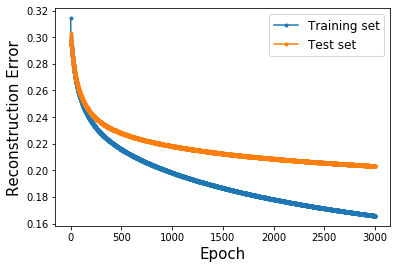

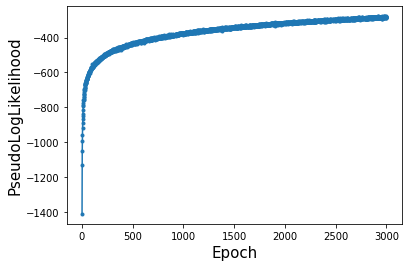

In [13]:
training_set = torch.Tensor(list(train_data_['state']))
training_set = training_set[torch.randperm(training_set.size()[0])]

test_set = torch.Tensor(list(test_data_['state']))


lr = 0.001
k_learning = 1
batch_size = 100
nb_epoch = 3000
k_sampling = 1

rbm = RBM(num_visible= training_set.shape[1], 
          num_hidden= training_set.shape[1], 
          bias= False,
          T= 1.0,
          use_cuda= True)
    
rbm.learn(training_set= training_set, 
          test_set= test_set,
          lr= lr, 
          nb_epoch= nb_epoch, 
          batch_size= batch_size,
          k_learning= k_learning,
          k_sampling = k_sampling,
          verbose= 1)

### Saving the trained model

In [14]:
nb_epoch= rbm.num_train_epochs()
Nv= training_set.shape[1]
Nh= training_set.shape[1]

name = 'RBM_model_T_complete_nv%d_nh%d_lr%.1E_k%d_bsize%d_nepochs%d' % (Nv,
                                                                        Nh,
                                                                        lr,
                                                                        k_learning,
                                                                        batch_size,
                                                                        nb_epoch)

PATH = '../RBM_trained_models/'+ name + '.pt'

torch.save(rbm, PATH)

### Weights distribution

In [15]:
W, v, h = rbm.parameters()

del v
del h
torch.cuda.empty_cache()

/home/rodrigo/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


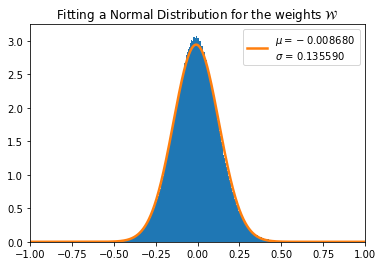

In [16]:
W_ = W.cpu().numpy().reshape((W.shape[0]*W.shape[1]))

# Plot normalized histogram 
plt.hist(W_, 
         bins= 1000, 
         density= True)

# Maximum and minimum of xticks to compute the theoretical distribution 
x_min, x_max = min(plt.xticks()[0]), max(plt.xticks()[0])  
domain = np.linspace(x_min, x_max, len(W_))

# Fitting a normal distribution
muW_, sigmaW_ = stats.norm.fit(W_) 

plot_pdf = stats.norm.pdf(domain, muW_, sigmaW_) # Fitting the PDF in the interval


plt.plot(domain, plot_pdf, linewidth= 2.5,
         label= '$\mu= %f$ \n$\sigma$ = %f' % (muW_, sigmaW_ ))

plt.title('Fitting a Normal Distribution for the weights ${\cal W}$')
plt.xlim([-1, 1])
plt.legend()
plt.show()